## Figure 3ef: Dosage-associated enterotype features

This script prints Figure 3e and 3f: 3e. Drug-enterotype feature relationships confirmed or uniquely revealed by dosage analysis. 
Scatterplot shows relationship between drug intake (binary yes/no) effect size (Cliff’s delta) and the drug dosage (continuous) effect size (Spearman’s rho) on enterotype features within each patient group. Features significantly affected in either analysis (two-sided, MWU FDR < 0.1) are shown in green colour (for potential drug effects) or purple colour (potential severity markers). Black circles and text highlight enterotype-drug-patient group associations that are followed up in panel f.

f. Relationship between drug dosage for metformin, statin and beta-blockers in three different MetaCardis patient groups and enterotype prevalence in each of these groups. 

Coloured areas represent the stacked enterotype prevalence along the drug dosage axis, with lines calculated as a fraction of enterotypes in patient subgroups for which drug dosage fall within the corresponding bin. Each dot represents a patient taking specific drug dose and classified into one of the four enterotypes. Random noise was added to dot coordinates for better visualization. 

Bact1: Bacteroides 1, Bact2, Bacteroides 2, Prev, Prevotella, Rum, Ruminococcus. 

Required file in the _input_data_ folder:

- Supplementary_Table_14_2019-09-13434.xlsx
- hub.enterotype.v1.data.frame.R
- hub.pheno.v8.data.frame.r
- cmd_dosages_20201210.r
- cmd_drugs_20201210.r

Figure is based on the data from Supplementary Table 14. 

In [69]:
# load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.tri import Triangulation
import random
%matplotlib inline

In [70]:
# read drug dose-enterotype associations from the table
fileFolder = './input_data/'
fileName = 'Supplementary_Table_14_2019-09-13434.xlsx'
sheetName = 'Data'
enteroanalysis_df = pd.read_excel(fileFolder + fileName,
                           sheet_name = sheetName)

In [71]:
# leave only dosage and intake effects
enteroanalysis_df = enteroanalysis_df[(enteroanalysis_df['Test'].str.find('intake')>=0) |
                                     (enteroanalysis_df['Test'].str.find('dosage')>=0)]

In [72]:
feature_set = [enteroanalysis_df['Effector'].iloc[i] + '_' + 
               enteroanalysis_df['Sample set'].iloc[i] + '_' + 
               enteroanalysis_df['Feature ID'].iloc[i] for i in range(len(enteroanalysis_df))]

In [73]:
# replace dosage by intake
feature_set = [item.replace('dosage', 'intake') for item in feature_set]
feature_set = list(set(feature_set))

In [74]:
# make a dataframe with effect sizes and fdr for each 
feature_intake_effect = []
feature_intake_FDR = []
feature_dosage_effect = []
feature_dosage_FDR = []
feature_congruence = []
for i in range(len(feature_set)):
    congr_appended=False
    curfeature = feature_set[i].split('_')
    curintake = enteroanalysis_df[(enteroanalysis_df['Effector']==curfeature[0]) &  
               (enteroanalysis_df['Sample set']==curfeature[1]) &  
               (enteroanalysis_df['Feature ID']==curfeature[2]) ]
    if len(curintake)>0:
        feature_intake_FDR.append(curintake['FDR'].values[0])
        feature_intake_effect.append(curintake['Effect size'].values[0])
        feature_congruence.append(curintake['Congruence'].values[0])
        congr_appended=True
    else:
        feature_intake_effect.append(np.nan)
        feature_intake_FDR.append(np.nan)
    # get the dosage
    curfeature = feature_set[i].replace('intake','dosage')
    curfeature = curfeature.split('_')
    curintake = enteroanalysis_df[(enteroanalysis_df['Effector']==curfeature[0]) &  
               (enteroanalysis_df['Sample set']==curfeature[1]) &  
               (enteroanalysis_df['Feature ID']==curfeature[2]) ]
    if len(curintake)>0:
        feature_dosage_FDR.append(curintake['FDR'].values[0])
        feature_dosage_effect.append(curintake['Effect size'].values[0])
        if not(congr_appended):
            feature_congruence.append(curintake['Congruence'].values[0])
    else:
        feature_dosage_effect.append(np.nan)
        feature_dosage_FDR.append(np.nan)
    

In [75]:
# Create a dataframe with drug intake and drug dosage effect information for each feature
feature_intake_dosage_df = pd.DataFrame({'intake_FDR': feature_intake_FDR,
                                        'intake_effect': feature_intake_effect,
                                        'dosage_FDR': feature_dosage_FDR,
                                        'dosage_effect': feature_dosage_effect,
                                        'Congruence': feature_congruence,
                                        }, index = feature_set)

Prepare data to plot

In [76]:
plotdata = feature_intake_dosage_df.copy()
plotdata['intake_effect'] = plotdata['intake_effect'].fillna(0)
plotdata['dosage_effect'] = plotdata['dosage_effect'].fillna(0)
plotdata['Congruence'] = plotdata['Congruence'].fillna('nan')
plotdata['intake_effect']=[item if item<1 else 1+(random.random()-0.5)/10 
                       for item in plotdata['intake_effect']]
plotdata['dosage_effect']=[item if item<1 else 1+(random.random()-0.5)/10 
                       for item in plotdata['dosage_effect']]
plotdata['intake_effect']=[item if item>-1 else -1+(random.random()-0.5)/10 
                       for item in plotdata['intake_effect']]
plotdata['dosage_effect']=[item if item>-1 else -1+(random.random()-0.5)/10 
                       for item in plotdata['dosage_effect']]
# add randomness in zeros
plotdata['intake_effect']=[item if item!=0 else (random.random()-0.5)/10 
                       for item in plotdata['intake_effect']]
plotdata['dosage_effect']=[item if item!=0 else (random.random()-0.5)/10 
                       for item in plotdata['dosage_effect']]

In [77]:
# leave only significant changes
plotdata_ns = plotdata[(plotdata['intake_FDR']>0.1) & (plotdata['dosage_FDR']>0.1)]
plotdata = plotdata[(plotdata['intake_FDR']<=0.1) | (plotdata['dosage_FDR']<=0.1)]

In [78]:
plotcolors = {'Same': '#9970AB',
              'Opposite': '#3A924C',
              'nan': '#CCCCCC'}#'#EBEBEB'}
curcolors = list([plotcolors[plotdata['Congruence'].iloc[i]] for i in range(len(plotdata)) ])

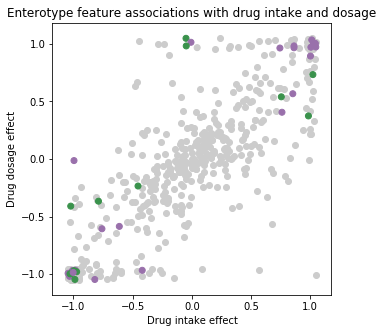

In [79]:
fig = plt.figure(figsize=(5,5))
plt.scatter(plotdata_ns['intake_effect'],plotdata_ns['dosage_effect'], c=plotcolors['nan'])
plt.scatter(plotdata['intake_effect'],plotdata['dosage_effect'], c=curcolors)
plt.xlabel('Drug intake effect')
plt.ylabel('Drug dosage effect')
plt.title('Enterotype feature associations with drug intake and dosage')

ax = plt.gca()
plt.rcParams['svg.fonttype'] = 'none'
filename = "Fig3e_scatter_effect_size_intake_vs_dosage_enterotypes"
# fig.savefig(filename + '.png',
#             format='png',
#             bbox_inches='tight')
# fig.savefig(filename + '.svg',
#             format='svg',
#             bbox_inches='tight')

### Plot enterotypes against dosage

In [98]:
# get enterotype, dosage and intake data per patient
fileFolder = './input_data/'

enterotypeFile = 'hub.enterotype.v1.data.frame.R'
enterotype_df = pd.read_csv(fileFolder + enterotypeFile, header=0, sep='\t')
entero_unique = list(set(enterotype_df['Feature']))

hubfilePhenotype = 'hub.pheno.v8.data.frame.r'
hubfileDosage = 'cmd_dosages_20201210.r'
hubfileDrug = 'cmd_drugs_20201210.r'

# read phenotype, drug and dose files
featuresPheno = pd.read_csv(fileFolder + hubfilePhenotype, sep='\t', index_col=0)
featuresDosage = pd.read_csv(fileFolder + hubfileDosage, sep='\t', index_col=0)
featuresDrug = pd.read_csv(fileFolder + hubfileDrug, sep='\t', index_col=0)

C:\Users\mazimmer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [99]:
#define enterotype order for figures
entero_unique = ['Prev', 'Rum', 'Bact1', 'Bact2']

In [100]:
# set all indeces to sample ID
featuresDosage = featuresDosage.set_index('SampleID')
featuresDrug = featuresDrug.set_index('SampleID')

In [101]:
# leave only predicted enterotypes 
enterotype_df = enterotype_df[enterotype_df['FeatureValue']==1]

### Perform enterotype-dosage analysis for other drugs

In [102]:
drug_array = ['beta', 'metformin', 'statin']
group_array = ['2b', '3', '5']
dose_array = [[-1, 0, 0.8, 1, 1.5],
              [-1, 0, 0.5, 1, 1.5],
              [-1, 0, 1 ,2, 4]]

In [103]:
entero_color_dict = {'Bact1':'#1f77b4',  
                    'Bact2':'#d62728', 
                    'Rum':'#ff7f0e',
                    'Prev':'#2ca02c'}

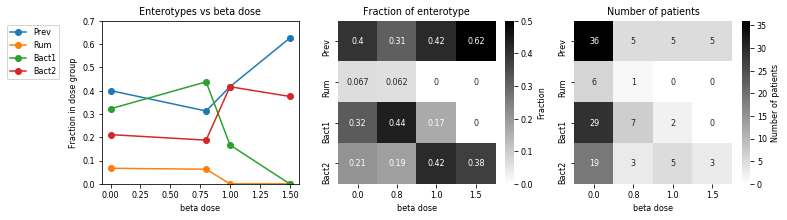

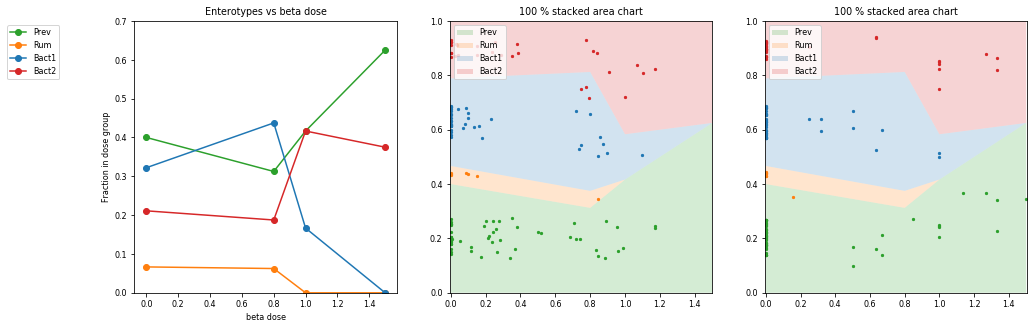

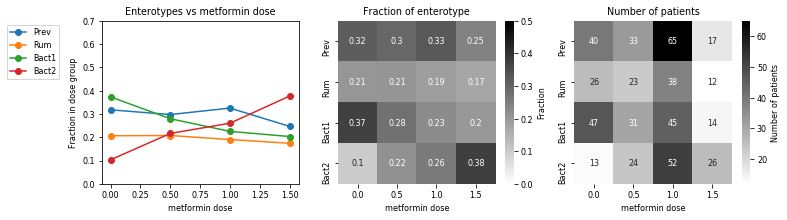

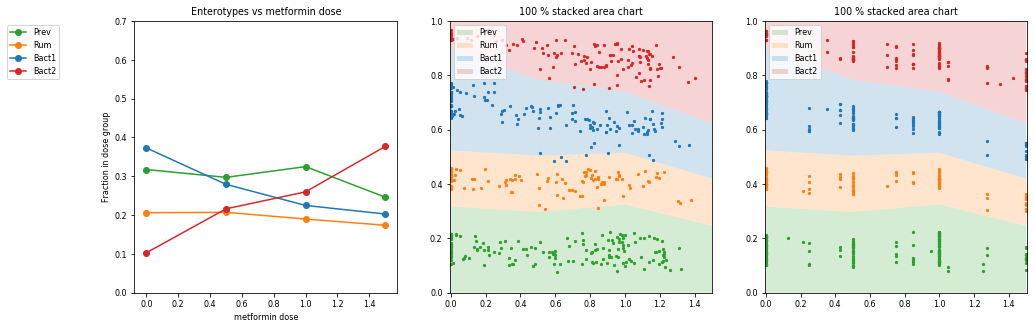

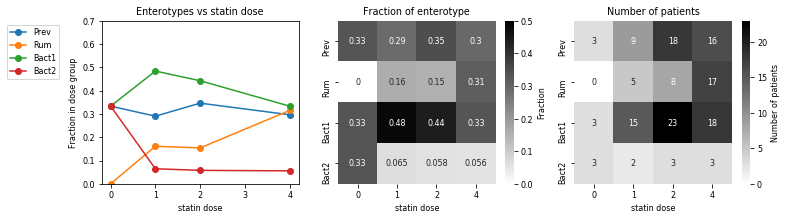

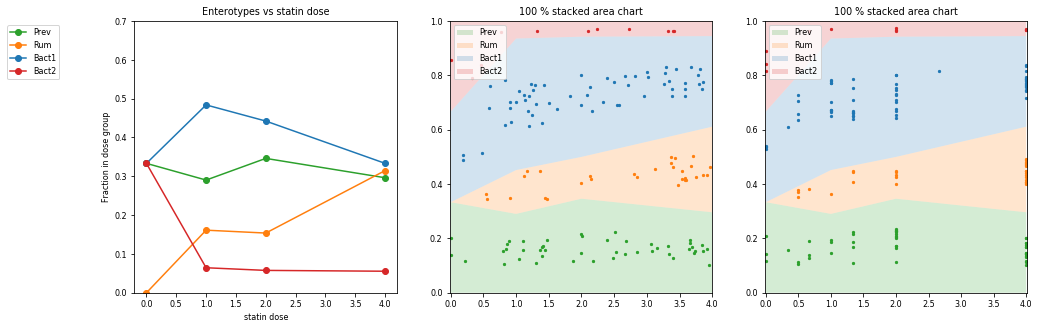

In [104]:
for idx in range(len(drug_array)):
    enterotype_drug_df = enterotype_df.copy()
    enterotype_drug_df = enterotype_drug_df.set_index('SampleID')

    # get dosage of the selected drug from the featuresDosage frame
    common_index = list(set(enterotype_drug_df.index).intersection(featuresDosage.index))

    curdrug = drug_array[idx]
    curcol = [item for item in featuresDosage.columns if (item.lower().find(curdrug)>=0)]

    enterotype_drug_df.loc[common_index,'Dose'] = featuresDosage.loc[common_index,curcol].values

    # get disease group for each sample from featuresPheno frame
    common_index = list(set(enterotype_drug_df.index).intersection(featuresPheno.index))
    enterotype_drug_df.loc[common_index,'PATGROUPFINAL_C'] = '0'
    cur_group = featuresPheno.loc[common_index,'Group'].to_frame()
    cur_group = cur_group[~cur_group.index.duplicated(keep='first')]
    enterotype_drug_df.loc[common_index,'PATGROUPFINAL_C'] = cur_group.loc[common_index,'Group'].values

    #Leave only one disease group

    curgroup = group_array[idx]
    enterotype_drug_df = enterotype_drug_df[enterotype_drug_df['PATGROUPFINAL_C']==curgroup]

    dose_unique = list(set(enterotype_drug_df['Dose']))
    dose_unique = [item for item in dose_unique if not(np.isnan(item))]
    dose_unique = sorted(dose_unique)

    dose_unique_step = dose_array[idx]

    # fraction enterotype per dose
    entero_dose_df = pd.DataFrame(0, index=dose_unique_step[1:], columns=entero_unique)
    for curentero in entero_unique:
        for i in range(1,len(dose_unique_step)):
            if i==(len(dose_unique_step)-1):
                curnumber = np.shape(enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=max(dose_unique))])

            else:
                curnumber = np.shape(enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=dose_unique_step[i])])
            entero_dose_df.loc[dose_unique_step[i], curentero] = curnumber[0]

    entero_dose_df_norm = entero_dose_df.copy()
    for i in range(entero_dose_df_norm.shape[0]):
        entero_dose_df_norm.iloc[i,:] = entero_dose_df_norm.iloc[i,:]/sum(entero_dose_df_norm.iloc[i,:])

    fig = plt.figure(figsize=(12, 3))
    plt.subplot(1,3,1)
    plotdataX = np.asarray(entero_dose_df_norm.index)
    for curentero in entero_unique:
        plotdataY = entero_dose_df_norm.loc[:,curentero]
        ax1 = plt.plot(plotdataX,plotdataY,'-o')
        #m, b = np.polyfit(plotdataX, plotdataY, 1)
        #plt.plot(plotdataX, m*plotdataX + b)
    plt.legend(entero_unique, loc='upper left', bbox_to_anchor=(-0.5, 1))
    plt.xlabel(curdrug + ' dose')
    plt.ylabel('Fraction in dose group')
    plt.title('Enterotypes vs ' + curdrug + ' dose')
    plt.ylim([0, 0.7])

    plt.subplot(1,3,2)
    plt.rcParams.update({'font.size': 8})
    g = sns.heatmap(entero_dose_df_norm.transpose(),yticklabels=1, cmap = 'binary', annot=True,
                    cbar_kws={'label': 'Fraction'},
                    vmin=0, vmax=0.5)
    plt.title('Fraction of enterotype')
    plt.xlabel(curdrug + ' dose')

    plt.subplot(1,3,3)
    plt.rcParams.update({'font.size': 8})
    g = sns.heatmap(entero_dose_df.transpose(),yticklabels=1, cmap = 'binary', annot=True,
                    cbar_kws={'label': 'Number of patients'})
    plt.title('Number of patients')
    plt.xlabel(curdrug + ' dose')

    plt.rcParams['svg.fonttype'] = 'none'
    filename = "Fig3f_enterotypes_vs_dose_WITHBINNING_" + curdrug + '_group_' + curgroup
 #     fig.savefig(filename + '.png',
#                 format='png',
#                 bbox_inches='tight')
#     fig.savefig(filename + '.svg',
#                 format='svg',
#                 bbox_inches='tight')

    fig = plt.figure(figsize=(16, 5))
    plt.subplot(1,3,1)
    plotdataX = np.asarray(entero_dose_df_norm.index)
    for curentero in entero_unique:
        plotdataY = entero_dose_df_norm.loc[:,curentero]
        ax1 = plt.plot(plotdataX,plotdataY,'-o',
                       color=entero_color_dict[curentero],
                       markerfacecolor=entero_color_dict[curentero])
        #m, b = np.polyfit(plotdataX, plotdataY, 1)
        #plt.plot(plotdataX, m*plotdataX + b)
    plt.legend(entero_unique, loc='upper left', bbox_to_anchor=(-0.5, 1))
    plt.xlabel(curdrug + ' dose')
    plt.ylabel('Fraction in dose group')
    plt.title('Enterotypes vs ' + curdrug + ' dose')
    plt.ylim([0, 0.7])

    plt.subplot(1,3,2)
    # Make the plot
    plt.stackplot(plotdataX,  entero_dose_df_norm.loc[:,entero_unique[0]],  
                  entero_dose_df_norm.loc[:,entero_unique[1]],
                  entero_dose_df_norm.loc[:,entero_unique[2]],
                  entero_dose_df_norm.loc[:,entero_unique[3]],
                  labels=entero_unique,
                  colors=[entero_color_dict[i] for i in entero_unique],
                  alpha = 0.2)
    plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.title('100 % stacked area chart')
    #plt.show()

    for i in range(1,len(dose_unique_step)):
        plotdataY = np.zeros([1,len(entero_unique)])
        for curentero in entero_unique:
            plotdataY[0][entero_unique.index(curentero)] = np.asarray(entero_dose_df_norm.loc[:,curentero])[i-1]
            if i==(len(dose_unique_step)-1):
                curnumber = enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=max(dose_unique))]

            else:
                curnumber = enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=dose_unique_step[i])]
            if i>=(len(dose_unique_step)-1):
                stepx = 1
            else:
                stepx = (dose_unique_step[i+1]-dose_unique_step[i])
            if curentero==entero_unique[0]:
                stepy = (plotdataY[0][entero_unique.index(curentero)])/2
            else:
                stepy = (sum(plotdataY[0][0:entero_unique.index(curentero)+1])-
                         sum(plotdataY[0][0:entero_unique.index(curentero)]))/2
            if i==len(dose_unique_step)-1:
                plt.scatter([max(0,dose_unique_step[i] + (random.random()-1)*stepx)
                         for j in range(curnumber.shape[0])], 
                         [sum(plotdataY[0][0:entero_unique.index(curentero)])+stepy + (random.random()-0.5)*stepy*0.75
                         for j in range(curnumber.shape[0])],
                         5,c = entero_color_dict[curentero])
            else:
                plt.scatter([max(0,dose_unique_step[i] + (random.random()-0.5)*stepx)
                         for j in range(curnumber.shape[0])], 
                         [sum(plotdataY[0][0:entero_unique.index(curentero)])+stepy + (random.random()-0.5)*stepy*0.75
                         for j in range(curnumber.shape[0])],
                         5,c = entero_color_dict[curentero])
    plt.subplot(1,3,3)
    # Make the plot
    plt.stackplot(plotdataX,  entero_dose_df_norm.loc[:,entero_unique[0]],  
                  entero_dose_df_norm.loc[:,entero_unique[1]],
                  entero_dose_df_norm.loc[:,entero_unique[2]],
                  entero_dose_df_norm.loc[:,entero_unique[3]],
                  labels=entero_unique,
                  colors=[entero_color_dict[i] for i in entero_unique],
                  alpha=0.2)
    plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.title('100 % stacked area chart')
    #plt.show()

    for i in range(1,len(dose_unique_step)):
        plotdataY = np.zeros([1,len(entero_unique)])
        for curentero in entero_unique:
            plotdataY[0][entero_unique.index(curentero)] = np.asarray(entero_dose_df_norm.loc[:,curentero])[i-1]
            if i==(len(dose_unique_step)-1):
                curnumber = enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=max(dose_unique))]

            else:
                curnumber = enterotype_drug_df[(enterotype_drug_df['Feature']==curentero) &
                            (enterotype_drug_df['Dose']>dose_unique_step[i-1]) &
                            (enterotype_drug_df['Dose']<=dose_unique_step[i])]
            if i>=(len(dose_unique_step)-1):
                stepx = 1
            else:
                stepx = (dose_unique_step[i+1]-dose_unique_step[i])
            if curentero==entero_unique[0]:
                stepy = (plotdataY[0][entero_unique.index(curentero)])/2
            else:
                stepy = (sum(plotdataY[0][0:entero_unique.index(curentero)+1])-
                         sum(plotdataY[0][0:entero_unique.index(curentero)]))/2
            plotX = curnumber['Dose'].copy()
            plotX[plotX>max(dose_unique_step)] = max(dose_unique_step)
            if i==len(dose_unique_step)-1:
                plt.scatter(plotX, 
                         [sum(plotdataY[0][0:entero_unique.index(curentero)])+stepy + (random.random()-0.5)*stepy*0.75
                         for j in range(curnumber.shape[0])],
                         5,c = entero_color_dict[curentero])
            else:
                plt.scatter(plotX, 
                         [sum(plotdataY[0][0:entero_unique.index(curentero)])+stepy + (random.random()-0.5)*stepy*0.75
                         for j in range(curnumber.shape[0])],
                         5,c = entero_color_dict[curentero])#'#434343'

    plt.rcParams['svg.fonttype'] = 'none'
    filename = "Fig3f_enterotypes_vs_dose_AREA_WITHBINNING_" + curdrug + '_group_' + curgroup
#     fig.savefig(filename + '.png',
#                 format='png',
#                 bbox_inches='tight')
#     fig.savefig(filename + '.svg',
#                 format='svg',
#                 bbox_inches='tight')        